In [1]:
import numpy as np
import gymnasium as gym
import random
import time
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

In [2]:
# Set render_mode="human" to enable rendering, else render_mode=None
env = gym.make("FrozenLake-v1", render_mode=None, is_slippery=False)
env.reset()

if env.render_mode == "human":
    env.render()

In [ ]:
# observation space - states
print(env.observation_space)
print(env.observation_space.n)

# action space - (0) left, (1) down, (2) right, (3) up
print(env.action_space)
print(env.action_space.n)

# Frozen Lake - Stochastic movement

Note that if `is_slippery` is True (default), then the agent will move in the intended direction with a probability of 1/3, otherwise they will move in either *perpendicular* direction with an equal probability of 1/3 in both directions. Hence, an action `right` may result in the agent moving, `down` or `up` instead!

In [3]:
env.reset()
terminated = False
while(not terminated):
    # generate and apply random action
    randomAction = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(randomAction)
    print(["left", "down", "right", "up"][randomAction])
    if not terminated : time.sleep(2)

print("Episode terminated!")

/Users/patrick/opt/anaconda3/envs/drl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:249: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


right
up
down
Episode terminated!


## Transition Probabilities

`p(s'|s,a)` denotes the transition probability to next state `s'` from current state `s` with action `a`.

In [ ]:
# env.P[state][action]
# Output: transition probability, next state, reward, is terminal
env.P[0][1]

# Building an agent

In [4]:
class FrozenLakeAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95
    ):
        """
        Initialize a Reinforcement Learning agent with an empty dictionary of state-action values (q_values),
        a learning rate and an epsilon.
        Args:
        - learning_rate: Amount with which to weight newly learned reward vs old reward (1 - lr)
        - initial epsilon: The initial probability w/ with we sample random action (exploration)
        - epsilon_decay: Value by which epsilon value decays through subtraction
        - final_epsilon: Epsilon value at which decay stops
        - discount_factor: The factor by which future rewards are counted, i.e. expected return on next state (recursive)
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.training_error = []
    
    def get_action(self, state: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon) -> exploitation. 
        Otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[state]))
    
    def update(
        self,
        state: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_state: tuple[int, int, bool]
    ):
        """
        Updates the Q-value of an action.
        The Q-value update is equivalent to the following weighting of old and new information by the learning rate:
        # self.q_values[state][action] = (1 - self.lr) * self.q_values[state][action] +
        #                                self.lr * (reward + self.discount_factor * future_q_value)
        The temporal difference is the difference between the old and new value over one (time) step.
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_state]) 
        temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[state][action]
        self.q_values[state][action] = self.q_values[state][action] + self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

# Write training loop

In [6]:
learning_rate = 0.01
n_episodes = 100_000
initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (n_episodes / 2)
final_epsilon = 0.1

agent = FrozenLakeAgent(
    learning_rate = learning_rate,
    initial_epsilon = initial_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    state, info = env.reset()
    done = False
    
    #play one episode
    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(state, action, reward, terminated, next_state)

        # update done status and state
        done = terminated or truncated
        state = next_state

    # once a game is finished we decay epsilon -> converge towards exploitation
    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:51<00:00, 1938.59it/s]


deque([array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([1.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], d

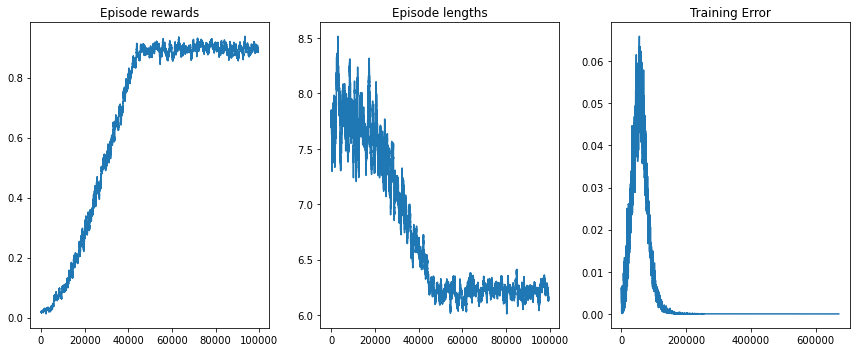

In [53]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards plot
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

# Episode lengths plot
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length # or: mode="same"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

# Training error plot
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="valid") / rolling_length # or: mode="same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

# Visualising the policy

Given our *state-action values* `q_values`,  we obtain *state values* by taking for each state the maximum state-action value: `state_value[state] = float(np.max(action_values))`. The optimal policy is obtained by taking the `argmax` instead of the `max`, thus yielding the action with the highest expected return in a given state. 

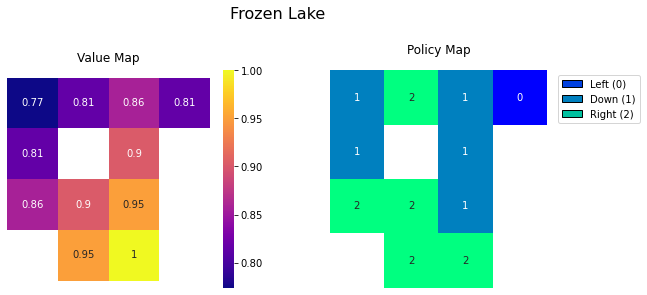

In [47]:
def create_grids(agent):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for state, action_values in agent.q_values.items():
        state_value[state] = float(np.max(action_values))
        policy[state] = int(np.argmax(action_values))

    X, Y = np.meshgrid(np.arange(0, 4), np.arange(0, 4))
    value_grid = np.apply_along_axis(lambda state: state_value[state[1] * 4 + state[0]], axis=2, arr=np.dstack([X, Y]))
    policy_grid = np.apply_along_axis(lambda state: policy[state[1] * 4 + state[0]] if state_value[state[1] * 4 + state[0]] > 0 else -1, axis=2, arr=np.dstack([X, Y]))

    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16, y=1.1)
    
    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1)
    ax1 = sns.heatmap(value_grid, linewidth=0, annot=True, mask=value_grid==0, cmap="plasma", square=True, yticklabels=False, xticklabels=False)
    ax1.set_title("Value Map", y=1.05)
    ax1.set_facecolor('none') # or 'whitesmoke'

    # plot the policy
    ax2 = fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, mask=value_grid==0, cmap="winter", cbar=False, square=True, yticklabels=False, xticklabels=False)
    ax2.set_title("Policy Map", y=1.05)
    ax2.set_facecolor('none')

    # add a legend
    cmap = sns.mpl_palette("winter", 3)
    legend_elements = [
        Patch(facecolor=cmap[0], edgecolor="black", label="Left (0)"),
        Patch(facecolor=cmap[1], edgecolor="black", label="Down (1)"),
        Patch(facecolor=cmap[2], edgecolor="black", label="Right (2)"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.45, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent)
fig1 = create_plots(value_grid, policy_grid, title="Frozen Lake")
plt.show()